In [1]:
import numpy as np
import configparser
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [2]:
from scipy import signal
from test_utils.denoise import ekg_denoise,baseline_wander_removal
from test_utils.test_utils import xml_reader,data_resample,predict,visualization,performance,print_cm,deal_minor_labels
from test_utils.beatbybeat import beatbybeat
from tensorflow import keras
from hg_blocks import PaddingLike
from distance import MultiHeadDistanceLayer  
from scipy.signal import find_peaks

config = configparser.ConfigParser()
config.read('./config.ini')
cl = [s.strip() for s in config['General']['labels'].split(',')] 
#/mnt/nas/homes/柳妹/arrhythmia-master-1130/wandb/run-20201230_153525-14ivdq3f/files/model-best.h5
#/mnt/nas/homes/柳妹/arrhythmia-master-1130/wandb/run-20210104_075059-rtt55vjk/files/model-best.h5 new peak

# Load model

In [3]:
model = keras.models.load_model(config['MIT']['model_dir'],
                                custom_objects={'PaddingLike': PaddingLike, "MultiHeadDistanceLayer":MultiHeadDistanceLayer}, compile = False)

# Load signal and predict 
## signal from xml

In [4]:
file = 'report.xml'
X_original = xml_reader(file)
signal_rate = 500
X, pred_peaks,pred_labels = predict(X_original, signal_rate, model, adjust = True)
pred_peaks,pred_labels

/mnt/nas/homes/柳妹/.local/share/virtualenvs/arrhythmia-master-1130-Sner7Htx/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 11 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(2500, 1)


([array([  48,  252,  420,  552,  720,  908, 1076, 1260, 1436, 1608, 1772,
         1940, 2088, 2252, 2420])],
 [array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])])

# Visualization

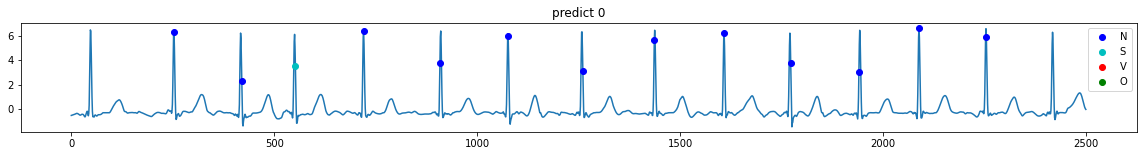

In [5]:
visualization(X,pred_peaks,pred_labels,cl)

# Load signal and predict
## signal is array type

### AHA

In [6]:
# AHA database
AHA = np.load("/mnt/nas/homes/柳妹/Arrhythmia/AHA database/AHA_data_denoise.npy",allow_pickle=True)
AHA_label = np.load("/mnt/nas/homes/柳妹/Arrhythmia/AHA database/AHA_label.npy",allow_pickle=True)
AHA_peak = np.load("/mnt/nas/homes/柳妹/Arrhythmia/AHA database/AHA_peak.npy",allow_pickle=True)

In [7]:
AHA_peak, AHA_label = deal_minor_labels(config["AHA"], cl, AHA_peak, AHA_label)

In [8]:
test_index = np.array([int(s.strip()) for s in config["AHA"]['test_index'].split(',')])

In [9]:
index = 6
signal_rate = 250
s = 0
# l = 250000 
# e = s+l if s+l < AHA[index].shape[0] else AHA[index].shape[0]-1
e = AHA[index].shape[0]-1
s_i = np.where(AHA_peak[index] >= s)[0]
e_i = np.where(AHA_peak[index] < e)[0]
X,pred_peaks,pred_labels,True_peaks,True_labels,c = predict(X_original = AHA[index][s:e], orignal_rate = signal_rate, model = model, 
                                   true_peaks = AHA_peak[index][s_i[0]:e_i[-1]+1]-s, true_labels = AHA_label[index][s_i[0]:e_i[-1]+1], cl = cl, adjust = True)


/mnt/nas/homes/柳妹/.local/share/virtualenvs/arrhythmia-master-1130-Sner7Htx/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(450034, 1)


In [10]:
cl_show= cl + ['miss','extra']
print_cm(c,cl_show)

     t/p      N     S     V     O  miss extra 
        N  2522     2    10    58     3     5 
        S     0     0     0     0     0    18 
        V     0     0     0     0     0     0 
        O     0     0     0     0     0     4 


# Visualization

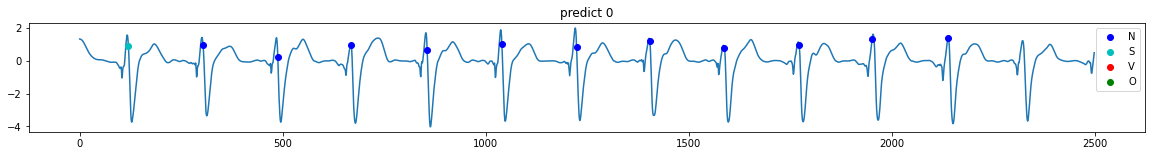

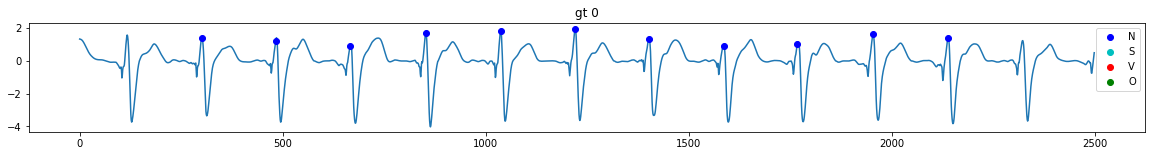

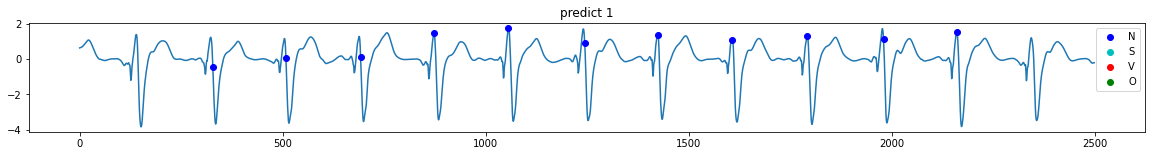

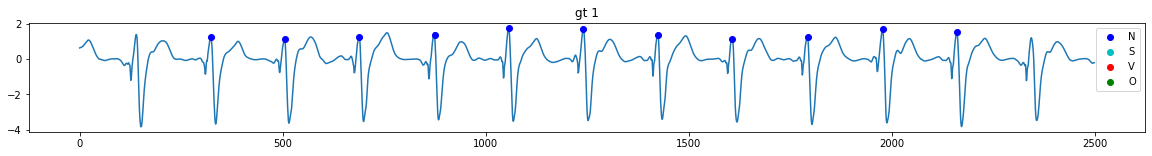

In [11]:
visualization(X,pred_peaks,pred_labels,cl,True_peaks,True_labels,2)

### MIT

In [12]:
# MIT database
MIT = np.load("/mnt/nas/homes/柳妹/Arrhythmia/MIT database/MIT_data_denoise.npy",allow_pickle=True)
MIT_label = np.load("/mnt/nas/homes/柳妹/Arrhythmia/MIT database/MIT_label.npy",allow_pickle=True)
MIT_peak = np.load("/mnt/nas/homes/柳妹/Arrhythmia/MIT database/MIT_peak.npy",allow_pickle=True)

In [13]:
MIT_peak, MIT_label = deal_minor_labels(config["MIT"], cl, MIT_peak, MIT_label)

In [19]:
index = 32
signal_rate = 360
s = 0
# l = 250000 
# e = s+l if s+l < MIT[index].shape[0] else MIT[index].shape[0]-1
e = MIT[index].shape[0]-1
s_i = np.where(MIT_peak[index] >= s)[0]
e_i = np.where(MIT_peak[index] < e)[0]
X,pred_peaks,pred_labels,True_peaks,True_labels,c = predict(X_original = MIT[index][s:e], orignal_rate = signal_rate, model = model, 
                                   true_peaks = (MIT_peak[index][s_i[0]:e_i[-1]+1])-s, true_labels = MIT_label[index][s_i[0]:e_i[-1]+1], cl = cl, adjust = True)


/mnt/nas/homes/柳妹/.local/share/virtualenvs/arrhythmia-master-1130-Sner7Htx/lib/python3.6/site-packages/pywt/_multilevel.py:45: UserWarning: Level value of 18 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


(451388, 1)


In [20]:
cl_show= cl + ['miss','extra']
print_cm(c,cl_show)

     t/p      N     S     V     O  miss extra 
        N  2279   308    13     1    19     3 
        S     1     7     8     0     6     1 
        V     8     7   128     0    61     1 
        O     0     0     0     0     0     0 


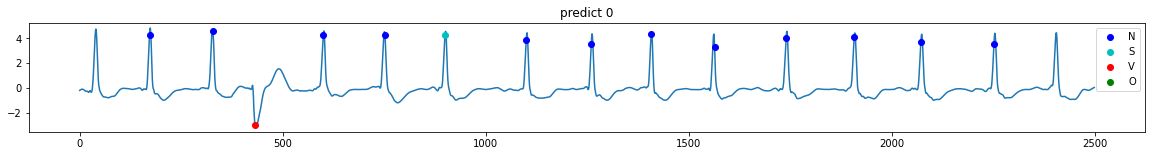

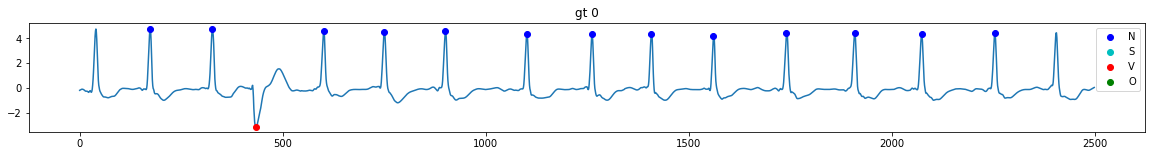

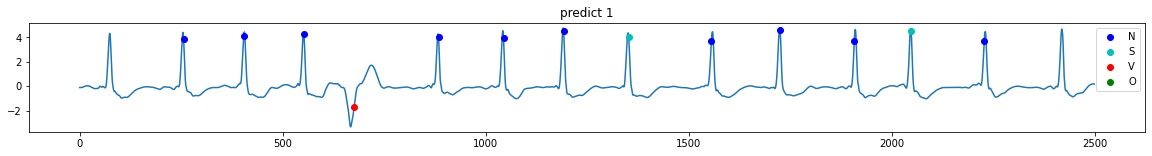

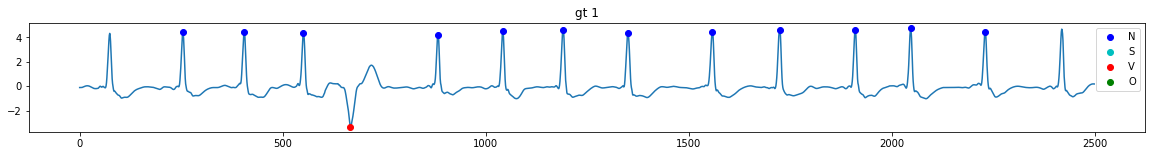

In [21]:
visualization(X,pred_peaks,pred_labels,cl,True_peaks,True_labels,2)